In [ ]:
import pandas as pd
import requests
import seaborn as sns

sns.set_theme(palette="deep")


In [ ]:
from io import BytesIO
from urllib.parse import urlencode

base_url = "anonymized"
public_key = "anonymized"

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()["href"]
response = requests.get(download_url)

path_to_dataset = "data"


parquet_file = BytesIO(response.content)
df = pd.read_parquet(parquet_file, engine="pyarrow")


IOStream.flush timed out


In [5]:
mmlu_entropy_df = df
mmlu_entropy_df.head()

,src,answer,options,category,question,cot_content,question_id,answer_index,total_tokens,meta_cluster,base_cluster,qwen2_ans_correct,qwen2_entropies,qwen2_every_token_info,qwen2_ans_token_index,qwen2_response,qwen2_input_embeddings,qwen2_think_embeddings,qwen2_answer_embeddings
0,ori_mmlu-jurisprudence,C,['There is no distinction between the two form...,law,Which of the following criticisms of Llewellyn...,NaN,1286,2,81,Legal Interpretation,Legal Theory Interpretations,True,"[0.5356510877609253, 1.2296925783157349, 0.256...","[[{""token_idx"": 1249, ""token_prob"": 0.77682381...",325,"To address this question, let's analyze each o...","{""min"": [-7.0, -7.03125, -7.5, -5.75, -8.3125,...","{""min"": [-5.65625, -3.9375, -5.4375, -5.03125,...","{""min"": [2.25, -1.609375, -0.1298828125, -0.30..."
1,ori_mmlu-international_law,E,"['Article 19', 'Article 11', 'Article 12', 'Ar...",law,Which of the following articles are not qualif...,NaN,1293,4,38,Legal Interpretation,Constitutional Law,False,"[0.06751268357038498, 0.12100628763437271, 0.0...","[[{""token_idx"": 641, ""token_prob"": 5.760890053...",420,To determine which of these articles are not q...,"{""min"": [-7.3125, -7.4375, -8.1875, -4.8125, -...","{""min"": [-5.84375, -3.765625, -5.75, -4.875, -...","{""min"": [2.1875, -1.6875, 0.1533203125, -0.261..."
2,ori_mmlu-management,D,"['Work delegation', 'Workload balancing', 'Wor...",business,As what is ensuring that one individual does n...,NaN,83,3,49,Economics & Finance MCQs,Business & Marketing Queries,False,"[0.5539455413818359, 1.391388177871704, 0.0642...","[[{""token_idx"": 785, ""token_prob"": 0.000854881...",275,To determine the correct term for ensuring tha...,"{""min"": [-6.65625, -8.0, -7.5, -6.1875, -8.75,...","{""min"": [-3.609375, -5.53125, -4.15625, -5.843...","{""min"": [2.015625, -1.34375, -0.46484375, 0.06..."
3,stemez-Business,J,"['$308.25', '$142.75', '$199.99', '$225.85', '...",business,Margaret Denault recently rented a truck to dr...,NaN,94,9,118,Economics & Finance MCQs,Business Finance Questions,False,"[0.2805074155330658, 1.1323387622833252, 0.270...","[[{""token_idx"": 1249, ""token_prob"": 0.92263787...",335,"To solve this problem, we need to calculate th...","{""min"": [-6.875, -6.875, -7.53125, -5.4375, -8...","{""min"": [-5.40625, -6.0, -6.0, -6.71875, -6.12...","{""min"": [2.25, -1.609375, -0.1298828125, -0.30..."
4,stemez-Business,I,"['$60,000', '$43,200', '$1,794', '$25,000', '$...",business,The tax rate in the town of Centerville is 11(...,NaN,104,8,102,Economics & Finance MCQs,Business Finance Questions,True,"[0.1345130205154419, 0.7144346237182617, 0.227...","[[{""token_idx"": 1249, ""token_prob"": 0.97047263...",443,"To solve this problem, we need to understand h...","{""min"": [-6.875, -6.875, -7.53125, -6.34375, -...","{""min"": [-5.375, -6.15625, -5.40625, -4.625, -...","{""min"": [2.109375, -0.984375, -0.06494140625, ..."


In [6]:
mmlu_entropy_df.value_counts("qwen2_ans_token_index", dropna=False)

qwen2_ans_token_index
-1      969
 393     50
 448     50
 404     47
 402     46
       ... 
 834      1
 984      1
 160      1
 159      1
 182      1
Length: 872, dtype: int64

In [7]:
# Filter out unanswered questions (qwen2_ans_token_index == -1)

mmlu_entropy_df_filtered = mmlu_entropy_df[mmlu_entropy_df["qwen2_ans_token_index"] != -1]

print(f"Len = {len(mmlu_entropy_df)} before filtering and {len(mmlu_entropy_df_filtered)} after filtering")

Len = 12032 before filtering and 11063 after filtering


In [ ]:
def entropy_counter(arr):
    sum = 0
    for i in arr:
        sum -= i["token_prob"] * np.log(i["token_prob"])
    return sum

In [ ]:
[
    tokenizer.encode(".\n\n"),
    tokenizer.encode(".\n"),
    tokenizer.encode("\n"),
    tokenizer.encode("\n\n"),
    tokenizer.encode(":\n\n"),
    tokenizer.encode(":\n"),
    tokenizer.encode("]\n"),
    tokenizer.encode("]\n\n"),
    tokenizer.encode(";\n\n"),
    tokenizer.encode(";\n"),
    tokenizer.encode(";"),
    tokenizer.encode("..."),
]


[[382],
 [624],
 [198],
 [271],
 [1447],
 [510],
 [921],
 [2533],
 [401],
 [280],
 [26],
 [1112]]

In [ ]:
tokenizer.encode("**\n\n"), tokenizer.encode("**\n"), tokenizer.encode("*\n\n"), tokenizer.encode("*\n")

([56177], [1019], [21518], [5618])

In [150]:
tokenizer.decode(151645)

'<|im_start|>'

In [ ]:
import json

import matplotlib.pyplot as plt
import numpy as np


def extract_cot_answer_from_row(tokenizer, row, column_every_token_info, column_ans_token_index):
    every_token_info = json.loads(row[column_every_token_info])
    answer_token_probs = every_token_info[row[column_ans_token_index]]

    max_prob_idx = np.argmax([item["token_prob"] for item in answer_token_probs])
    answer_token = answer_token_probs[max_prob_idx]["token_idx"]
    return tokenizer.decode(answer_token)


def extract_cot_answer_entropy_from_row(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    return answer_token_entropy


def visualize_entropy_all(df, x, hue, model_name=None):
    plt.figure(figsize=(14, 6))
    ax = sns.histplot(
        df,
        x=x,
        bins=30,
        hue=hue,
        hue_order=[False, True],
        multiple="dodge",
    )
    ax.set_xlabel("Entropy")
    ax.set_ylabel("Count")
    plt.legend(
        handles=ax.get_legend().legend_handles, labels=["Incorrect", "Correct"], title="Answer", loc="upper right"
    )
    if model_name is not None:
        plt.title(model_name)
    # plt.savefig("entropy_phi4.pdf")

    plt.figure(figsize=(14, 6))
    ax = sns.histplot(
        df,
        x=x,
        bins=30,
        hue=hue,
        hue_order=[False, True],
        multiple="fill",
    )
    ax.set_xlabel("Entropy")
    ax.set_ylabel("Proportion")
    plt.legend(handles=ax.get_legend().legend_handles, labels=["Incorrect", "Correct"], title="Answer")
    if model_name is not None:
        plt.title(model_name)


In [144]:
import ast

len(ast.literal_eval(mmlu_entropy_df_filtered.qwen2_entropies.iloc[0]))

328

In [11]:
from transformers import AutoTokenizer

# from reasoning_fine_tune.utils.processing import extract_cot_answer_entropy_from_row, extract_cot_answer_from_row

MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

mmlu_entropy_df_filtered["qwen2_answer"] = mmlu_entropy_df_filtered.apply(
    lambda row: extract_cot_answer_from_row(tokenizer, row, "qwen2_every_token_info", "qwen2_ans_token_index"), axis=1
)
mmlu_entropy_df_filtered["qwen2_answer_entropy"] = mmlu_entropy_df_filtered.apply(
    lambda row: extract_cot_answer_entropy_from_row(row, "qwen2_entropies", "qwen2_ans_token_index"), axis=1
)

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-05-19 03:26:19.047542: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 03:26:20.695562: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-19 03:26:26.607726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_10979/159539326

In [ ]:
def aver(row, column_entropies, column_ans_token_index, every):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]
    ev = json.loads(row[every])
    prob_max = []
    for sublist in ev:
        maxi = 0
        maxii = 0
        for i in sublist:
            if i["token_prob"] > maxi:
                maxii = maxi
                maxi = i["token_prob"]
        prob_max.append(1 - (maxi - maxii))
    return np.mean(prob_max)
    # return


mmlu_entropy_df_filtered["qwen2_prob_diff_ent"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_ans_token_index", "qwen2_every_token_info"), axis=1
)

In [ ]:
def aver(row, column_entropies, column_ans_token_index, every):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]
    ev = json.loads(row[every])
    prob_max = []
    for sublist in ev:
        prob_max.append(np.max([item["token_prob"] for item in sublist]))

    # return answer_token_entropy
    return prob_max


mmlu_entropy_df_filtered["qwen2_max_prob"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_ans_token_index", "qwen2_every_token_info"), axis=1
)


def aver(row, column_entropies, column_ans_token_index, every):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]
    ev = json.loads(row[every])
    prob_max = []
    for sublist in ev:
        prob_max.append(sublist[np.argmax([item["token_prob"] for item in sublist])]["token_idx"])

    # return answer_token_entropy
    return prob_max


mmlu_entropy_df_filtered["qwen2_argmax_prob"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_ans_token_index", "qwen2_every_token_info"), axis=1
)

In [ ]:
def aver(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    # return answer_token_entropy
    return np.mean([ind for ind in entropies])


mmlu_entropy_df_filtered["qwen2_answer_entropy_cot_mean"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_ans_token_index"), axis=1
)

/tmp/ipykernel_10979/4177692007.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["qwen2_answer_entropy_cot_mean"] = mmlu_entropy_df_filtered.apply(


In [ ]:
def aver(row, column_entropies, column_ans_token_index, every):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    # return answer_token_entropy
    return np.max([ind for ind in entropies])


mmlu_entropy_df_filtered["qwen2_answer_entropy_cot_max"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_ans_token_index", "qwen2_every_token_info"), axis=1
)

In [ ]:
def aver(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    # return answer_token_entropy
    # return np.mean([ind for ind in entropies])
    return np.abs(np.max([ind for ind in entropies]) - answer_token_entropy)


mmlu_entropy_df_filtered["qwen2_answer_entropy_marg"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_ans_token_index"), axis=1
)

/tmp/ipykernel_10979/3911279233.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["qwen2_answer_entropy_marg"] = mmlu_entropy_df_filtered.apply(


In [ ]:
def aver(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    # ev = json.loads(row[every])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    top1, top2 = sorted(entropies, reverse=True)[:2]

    return abs(top1 - top2)
    # why = np.argmax([ind['token_prob'] for ind in ast.literal_eval(row[every])[check]])

    # piv = ast.literal_eval(mmlu_entropy_df_filtered.qwen2_every_token_info.iloc[ran])[check][why]['token_idx']


mmlu_entropy_df_filtered["qwen2_answer_entropy_top_diff"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_ans_token_index"), axis=1
)

<h2>Sequence mean entropy<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.598453,0.196906,11049,0.411802,Qwen-3b,qwen2_answer_entropy_sequence_mean
1,law,0.502526,0.005053,1099,0.238399,Qwen-3b,qwen2_answer_entropy_sequence_mean
2,business,0.656664,0.313328,734,0.452316,Qwen-3b,qwen2_answer_entropy_sequence_mean
3,psychology,0.629238,0.258477,792,0.507576,Qwen-3b,qwen2_answer_entropy_sequence_mean
4,chemistry,0.620512,0.241024,935,0.414973,Qwen-3b,qwen2_answer_entropy_sequence_mean
5,biology,0.567449,0.134899,707,0.561528,Qwen-3b,qwen2_answer_entropy_sequence_mean
6,history,0.556825,0.113651,380,0.355263,Qwen-3b,qwen2_answer_entropy_sequence_mean
7,other,0.557468,0.114936,912,0.383772,Qwen-3b,qwen2_answer_entropy_sequence_mean
8,physics,0.624715,0.249429,1126,0.417407,Qwen-3b,qwen2_answer_entropy_sequence_mean
9,computer science,0.579235,0.158471,391,0.365729,Qwen-3b,qwen2_answer_entropy_sequence_mean


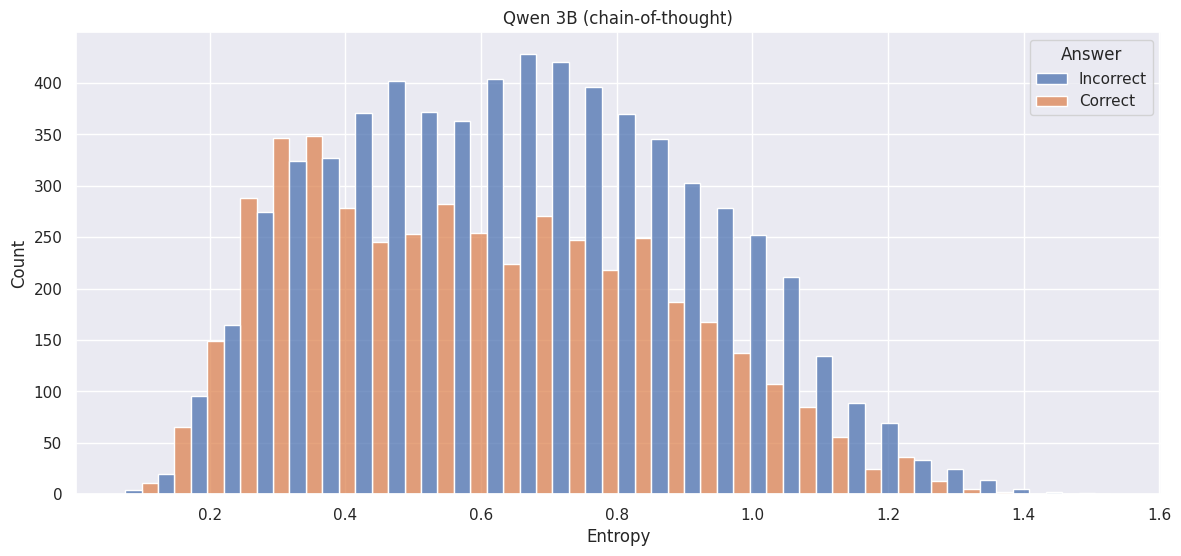

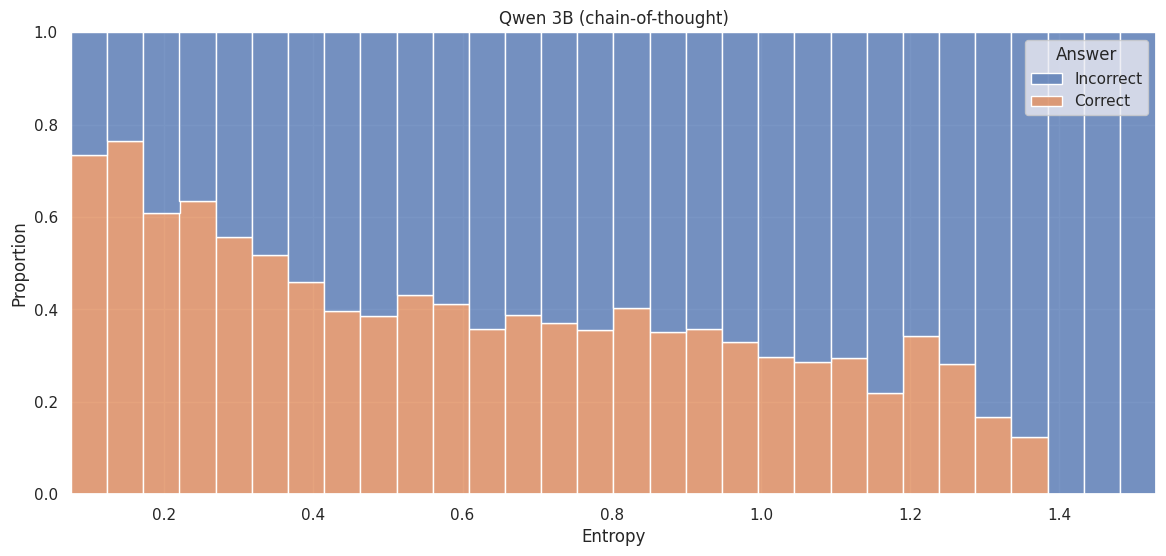

In [ ]:
splitters = [382, 624, 198, 271, 1447, 510, 921, 2533, 401, 280, 26, 1112, 56177, 1019, 21518, 5618, 151645]
name = "qwen2_answer_entropy_sequence_mean"


def aver(row, column_entropies, args):
    entropies = json.loads(row[column_entropies])
    # print()
    # answer_token_entropy = entropies[row[column_ans_token_index]]

    # top1, top2 = sorted(entropies, reverse=True)[:2]
    entr = []
    seq_entr = []
    counter = 0
    # print(row[args])
    for sublist in row[args]:
        # prob_max = np.argmax([item['token_prob'] for item in sublist])
        entr.append(entropies[counter])
        # print(entr)
        if sublist in splitters:
            # print(entr)
            seq_entr.append(np.mean(entr))
            # print(np.mean(entr))

            entr = []
        counter += 1
    return np.mean(seq_entr)


mmlu_entropy_df_filtered["qwen2_answer_entropy_sequence_mean"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_argmax_prob"), axis=1
)


visualize_entropy_all(mmlu_entropy_df_filtered, name, "qwen2_ans_correct", model_name="Qwen 3B (chain-of-thought)")


# from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category
model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col=name,
    model_name=model_title,
)
roc_auc_res


<h2>Sequence mean max entropy<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.623668,0.247335,11049,0.411802,Qwen-3b,qwen2_answer_entropy_sequence_mean_max
1,law,0.565036,0.130072,1099,0.238399,Qwen-3b,qwen2_answer_entropy_sequence_mean_max
2,business,0.689070,0.378139,734,0.452316,Qwen-3b,qwen2_answer_entropy_sequence_mean_max
3,psychology,0.574665,0.149330,792,0.507576,Qwen-3b,qwen2_answer_entropy_sequence_mean_max
4,chemistry,0.613628,0.227256,935,0.414973,Qwen-3b,qwen2_answer_entropy_sequence_mean_max
5,biology,0.569456,0.138913,707,0.561528,Qwen-3b,qwen2_answer_entropy_sequence_mean_max
6,history,0.564021,0.128042,380,0.355263,Qwen-3b,qwen2_answer_entropy_sequence_mean_max
7,other,0.586665,0.173330,912,0.383772,Qwen-3b,qwen2_answer_entropy_sequence_mean_max
8,physics,0.648761,0.297522,1126,0.417407,Qwen-3b,qwen2_answer_entropy_sequence_mean_max
9,computer science,0.572299,0.144597,391,0.365729,Qwen-3b,qwen2_answer_entropy_sequence_mean_max


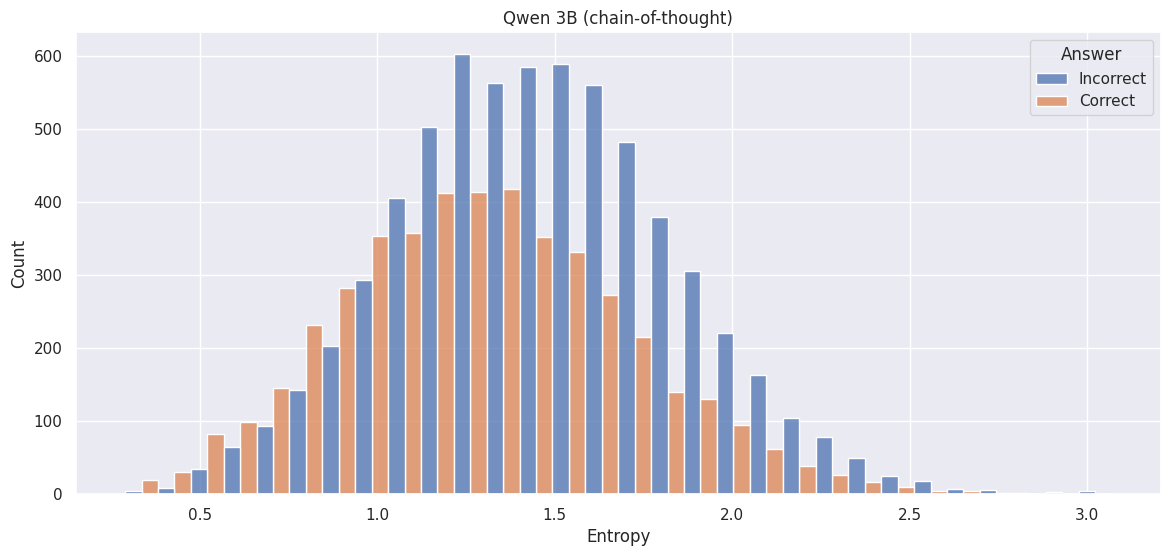

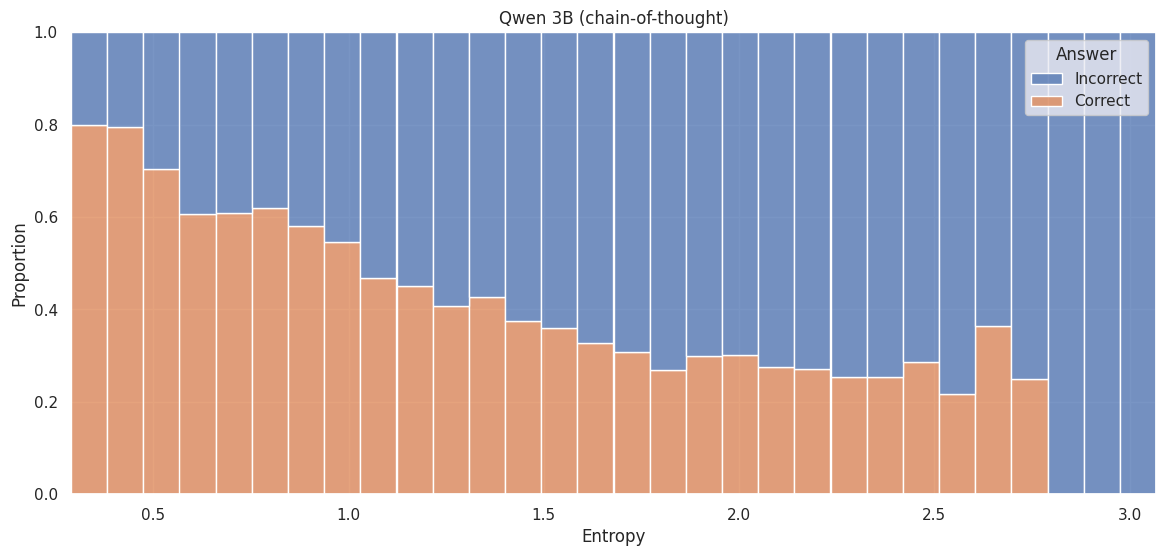

In [ ]:
def aver(row, column_entropies, args):
    entropies = json.loads(row[column_entropies])
    entr = []
    seq_entr = []
    counter = 0
    for sublist in row[args]:
        entr.append(entropies[counter])

        if sublist in splitters:
            seq_entr.append(np.mean(entr))

            entr = []
        counter += 1
    return np.max(seq_entr)


mmlu_entropy_df_filtered["qwen2_answer_entropy_sequence_mean_max"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_argmax_prob"), axis=1
)

name = "qwen2_answer_entropy_sequence_mean_max"

visualize_entropy_all(mmlu_entropy_df_filtered, name, "qwen2_ans_correct", model_name="Qwen 3B (chain-of-thought)")


model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col=name,
    model_name=model_title,
)
roc_auc_res


<h2>Sequence max mean entropy<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.590113,0.180227,11049,0.411802,Qwen-3b,qwen2_answer_entropy_sequence_max_mean
1,law,0.494806,0.010388,1099,0.238399,Qwen-3b,qwen2_answer_entropy_sequence_max_mean
2,business,0.647815,0.295630,734,0.452316,Qwen-3b,qwen2_answer_entropy_sequence_max_mean
3,psychology,0.605007,0.210014,792,0.507576,Qwen-3b,qwen2_answer_entropy_sequence_max_mean
4,chemistry,0.610358,0.220717,935,0.414973,Qwen-3b,qwen2_answer_entropy_sequence_max_mean
5,biology,0.567791,0.135581,707,0.561528,Qwen-3b,qwen2_answer_entropy_sequence_max_mean
6,history,0.573908,0.147816,380,0.355263,Qwen-3b,qwen2_answer_entropy_sequence_max_mean
7,other,0.552267,0.104535,912,0.383772,Qwen-3b,qwen2_answer_entropy_sequence_max_mean
8,physics,0.623333,0.246666,1126,0.417407,Qwen-3b,qwen2_answer_entropy_sequence_max_mean
9,computer science,0.528254,0.056508,391,0.365729,Qwen-3b,qwen2_answer_entropy_sequence_max_mean


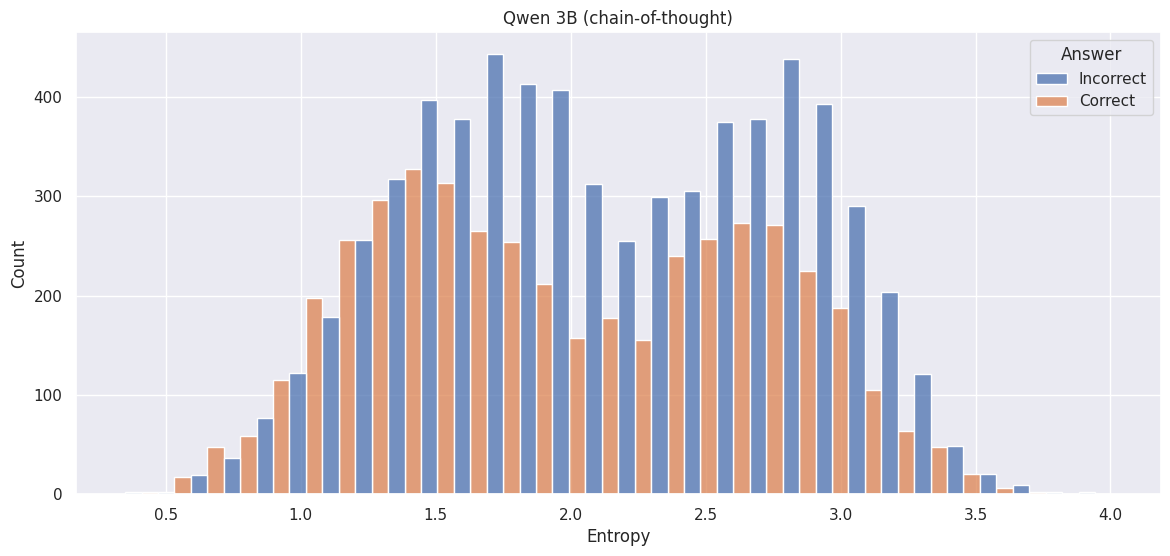

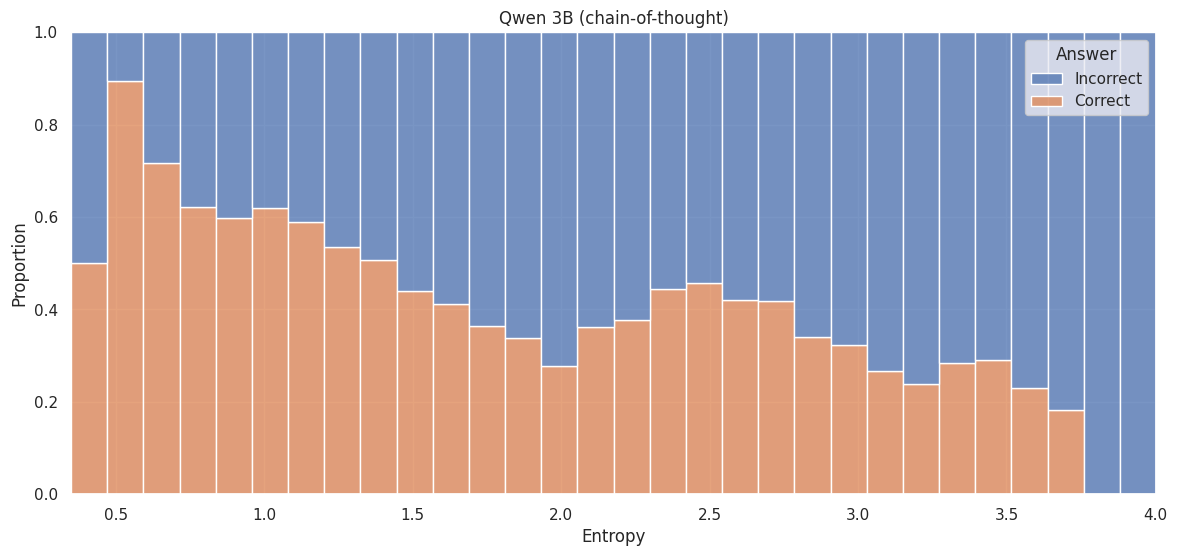

In [ ]:
splitters = [382, 624, 198, 271, 1447, 510, 921, 2533, 401, 280, 26, 1112, 56177, 1019, 21518, 5618, 151645]


def aver(row, column_entropies, args):
    entropies = json.loads(row[column_entropies])
    entr = []
    seq_entr = []
    counter = 0
    for sublist in row[args]:
        entr.append(entropies[counter])

        if sublist in splitters:
            seq_entr.append(np.max(entr))

            entr = []
        counter += 1
    return np.mean(seq_entr)


mmlu_entropy_df_filtered["qwen2_answer_entropy_sequence_max_mean"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_argmax_prob"), axis=1
)

name = "qwen2_answer_entropy_sequence_max_mean"

visualize_entropy_all(mmlu_entropy_df_filtered, name, "qwen2_ans_correct", model_name="Qwen 3B (chain-of-thought)")


model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col=name,
    model_name=model_title,
)
roc_auc_res


In [ ]:
option_ids = [str(i + 1) for i in range(20)]
# 0 is a special exception for "do not know"
option_ids_w_fallback = option_ids + ["0"]


def validate_mmlu_answer(answer):
    return str(answer) in option_ids_w_fallback


def keep_only_valid_and_known_answers(df, column_name, option_ids=option_ids):
    return df[df[column_name].isin(option_ids)]

In [57]:
# Filter out incorrectly formatted answers (answer token is not one of the options)
# from reasoning_fine_tune.utils.validation import keep_only_valid_and_known_answers

print(mmlu_entropy_df_filtered.value_counts("qwen2_answer", dropna=False))

mmlu_entropy_df_filtered = keep_only_valid_and_known_answers(mmlu_entropy_df_filtered, "qwen2_answer")

print(mmlu_entropy_df_filtered.value_counts("qwen2_answer", dropna=False))

qwen2_answer
1         1960
3         1678
4         1368
2         1253
7         1113
5          965
9          965
8          936
6          811
0            4
number       4
none         3
F            1
answer       1
f            1
dtype: int64
qwen2_answer
1    1960
3    1678
4    1368
2    1253
7    1113
5     965
9     965
8     936
6     811
dtype: int64


<h2>Entropy of Answer<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.680956,0.361912,11049,0.411802,Qwen-3b,qwen2_answer_entropy
1,law,0.600016,0.200033,1099,0.238399,Qwen-3b,qwen2_answer_entropy
2,business,0.680843,0.361686,734,0.452316,Qwen-3b,qwen2_answer_entropy
3,psychology,0.726400,0.452800,792,0.507576,Qwen-3b,qwen2_answer_entropy
4,chemistry,0.645461,0.290921,935,0.414973,Qwen-3b,qwen2_answer_entropy
5,biology,0.773324,0.546648,707,0.561528,Qwen-3b,qwen2_answer_entropy
6,history,0.622706,0.245412,380,0.355263,Qwen-3b,qwen2_answer_entropy
7,other,0.631662,0.263325,912,0.383772,Qwen-3b,qwen2_answer_entropy
8,physics,0.683838,0.367676,1126,0.417407,Qwen-3b,qwen2_answer_entropy
9,computer science,0.679450,0.358899,391,0.365729,Qwen-3b,qwen2_answer_entropy


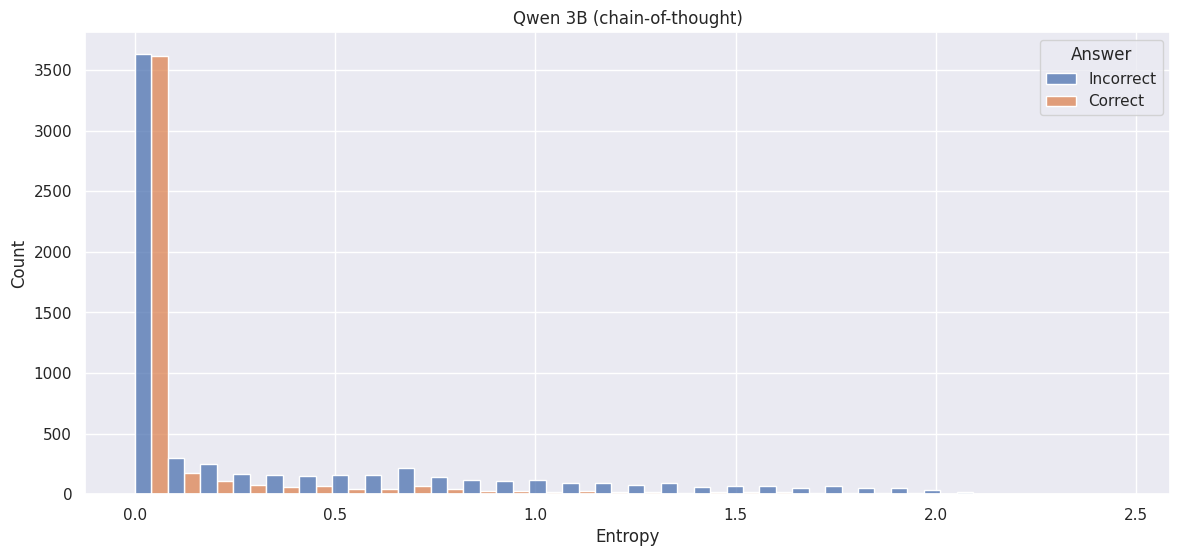

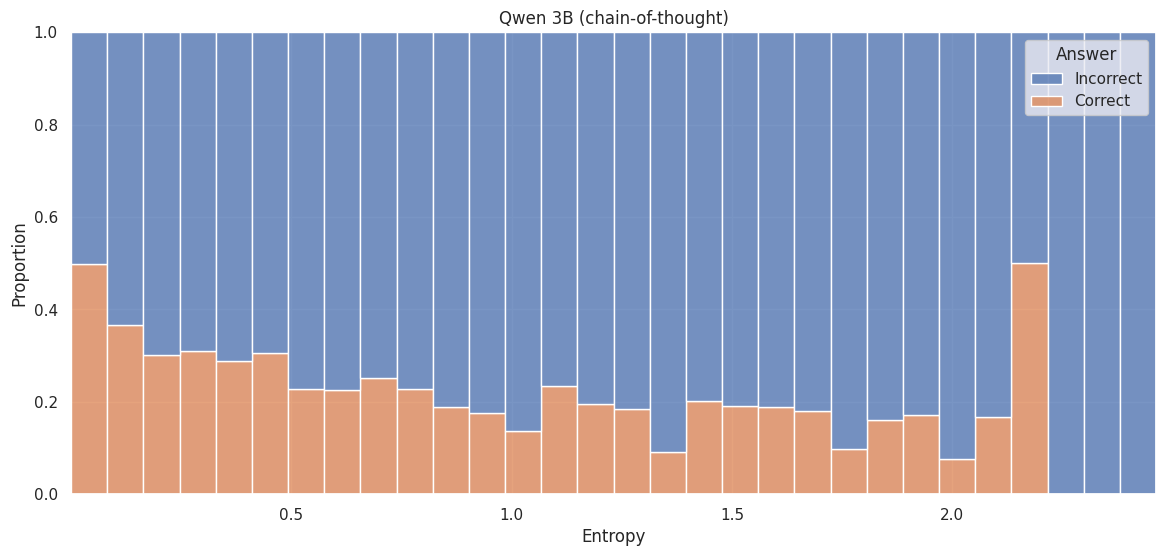

In [187]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered, "qwen2_answer_entropy", "qwen2_ans_correct", model_name="Qwen 3B (chain-of-thought)"
)

# from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category
model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col="qwen2_answer_entropy",
    model_name=model_title,
)
roc_auc_res

<h2>COT max entropy<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.632622,0.265243,11049,0.411802,Qwen-3b,qwen2_answer_entropy_cot_max
1,law,0.506658,0.013315,1099,0.238399,Qwen-3b,qwen2_answer_entropy_cot_max
2,business,0.715242,0.430483,734,0.452316,Qwen-3b,qwen2_answer_entropy_cot_max
3,psychology,0.585343,0.170685,792,0.507576,Qwen-3b,qwen2_answer_entropy_cot_max
4,chemistry,0.650917,0.301834,935,0.414973,Qwen-3b,qwen2_answer_entropy_cot_max
5,biology,0.614455,0.228910,707,0.561528,Qwen-3b,qwen2_answer_entropy_cot_max
6,history,0.561119,0.122237,380,0.355263,Qwen-3b,qwen2_answer_entropy_cot_max
7,other,0.559975,0.119949,912,0.383772,Qwen-3b,qwen2_answer_entropy_cot_max
8,physics,0.691557,0.383115,1126,0.417407,Qwen-3b,qwen2_answer_entropy_cot_max
9,computer science,0.553209,0.106418,391,0.365729,Qwen-3b,qwen2_answer_entropy_cot_max


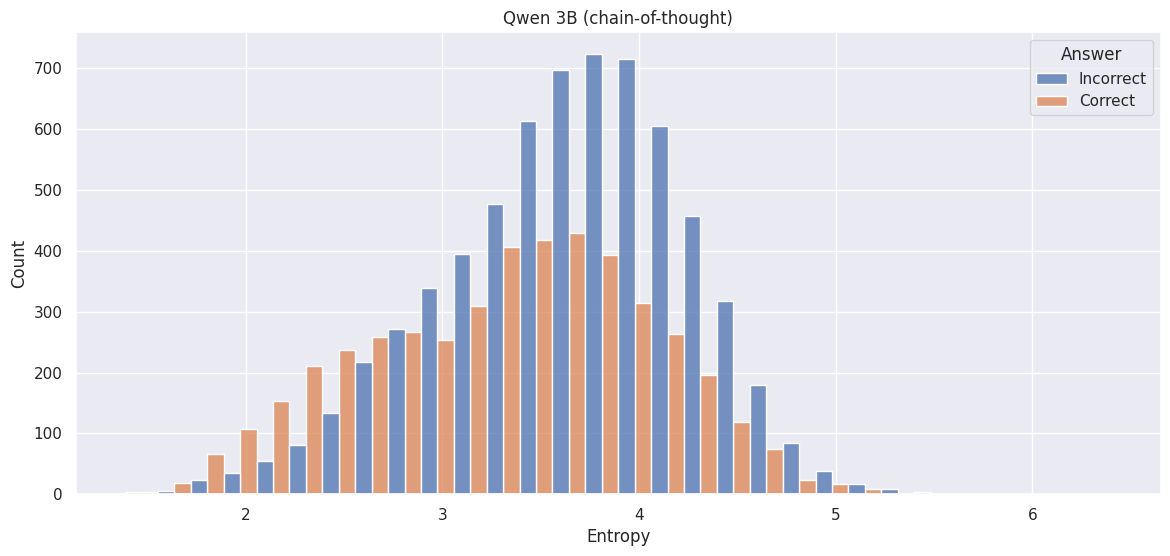

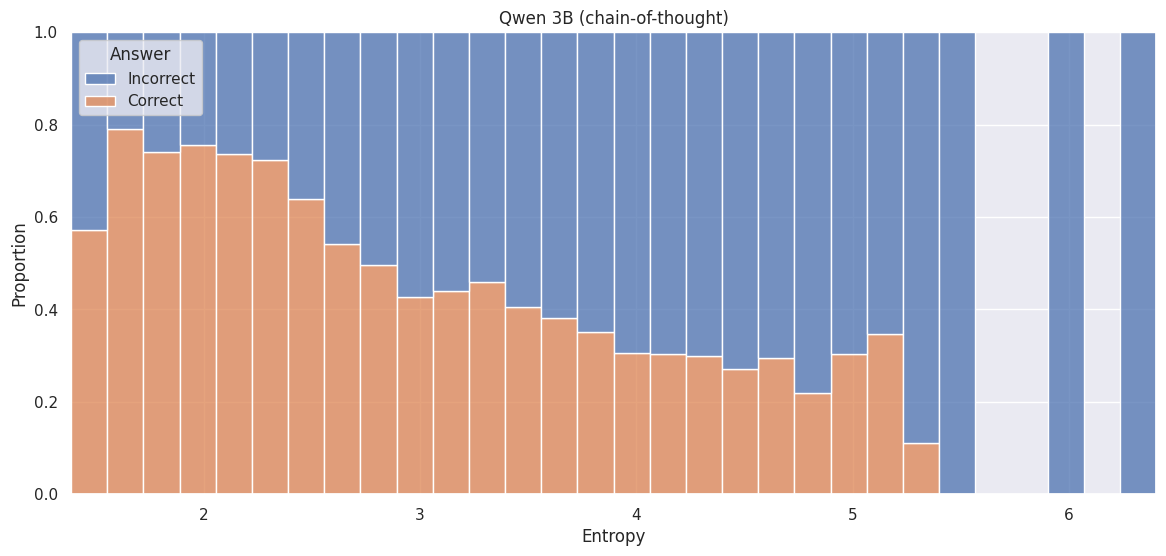

In [ ]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered,
    "qwen2_answer_entropy_cot_max",
    "qwen2_ans_correct",
    model_name="Qwen 3B (chain-of-thought)",
)

roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col="qwen2_answer_entropy_cot_max",
    model_name=model_title,
)
roc_auc_res


<h2>COT mean entropy<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.592887,0.185774,11049,0.411802,Qwen-3b,qwen2_answer_entropy_cot_mean
1,law,0.479379,0.041241,1099,0.238399,Qwen-3b,qwen2_answer_entropy_cot_mean
2,business,0.659863,0.319727,734,0.452316,Qwen-3b,qwen2_answer_entropy_cot_mean
3,psychology,0.629685,0.259370,792,0.507576,Qwen-3b,qwen2_answer_entropy_cot_mean
4,chemistry,0.625841,0.251682,935,0.414973,Qwen-3b,qwen2_answer_entropy_cot_mean
5,biology,0.576956,0.153912,707,0.561528,Qwen-3b,qwen2_answer_entropy_cot_mean
6,history,0.555223,0.110446,380,0.355263,Qwen-3b,qwen2_answer_entropy_cot_mean
7,other,0.544377,0.088754,912,0.383772,Qwen-3b,qwen2_answer_entropy_cot_mean
8,physics,0.620826,0.241652,1126,0.417407,Qwen-3b,qwen2_answer_entropy_cot_mean
9,computer science,0.610365,0.220731,391,0.365729,Qwen-3b,qwen2_answer_entropy_cot_mean


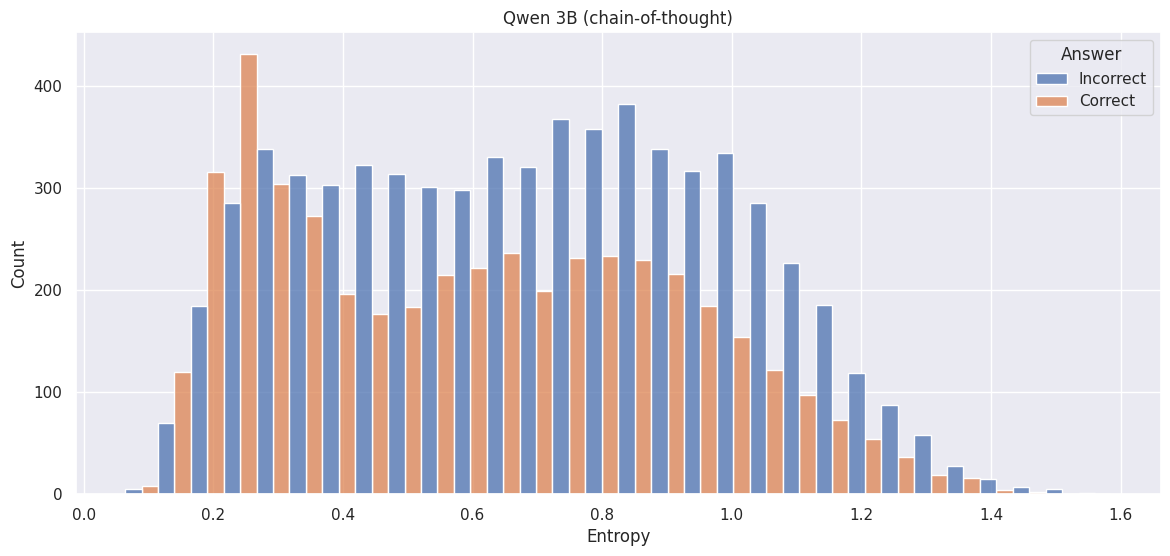

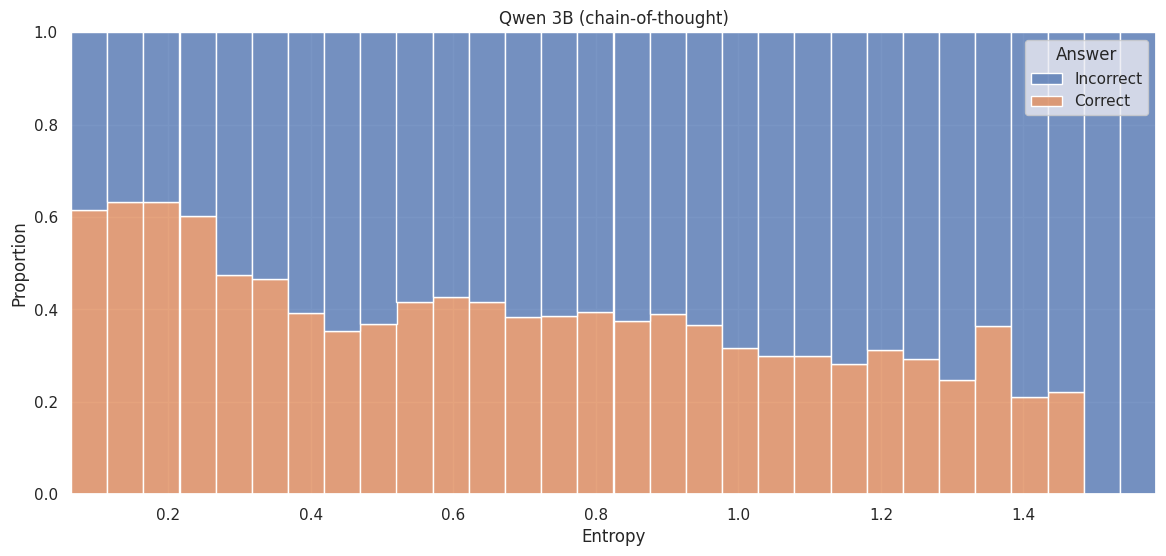

In [ ]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered,
    "qwen2_answer_entropy_cot_mean",
    "qwen2_ans_correct",
    model_name="Qwen 3B (chain-of-thought)",
)

roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col="qwen2_answer_entropy_cot_mean",
    model_name=model_title,
)
roc_auc_res


<h2>Max COT entropy and answer entropy difference<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.544869,0.089739,11049,0.411802,Qwen-3b,qwen2_answer_entropy_marg
1,law,0.442023,0.115954,1099,0.238399,Qwen-3b,qwen2_answer_entropy_marg
2,business,0.605946,0.211892,734,0.452316,Qwen-3b,qwen2_answer_entropy_marg
3,psychology,0.474895,0.050210,792,0.507576,Qwen-3b,qwen2_answer_entropy_marg
4,chemistry,0.552753,0.105505,935,0.414973,Qwen-3b,qwen2_answer_entropy_marg
5,biology,0.469578,0.060843,707,0.561528,Qwen-3b,qwen2_answer_entropy_marg
6,history,0.486440,0.027120,380,0.355263,Qwen-3b,qwen2_answer_entropy_marg
7,other,0.490539,0.018922,912,0.383772,Qwen-3b,qwen2_answer_entropy_marg
8,physics,0.555738,0.111475,1126,0.417407,Qwen-3b,qwen2_answer_entropy_marg
9,computer science,0.464189,0.071622,391,0.365729,Qwen-3b,qwen2_answer_entropy_marg


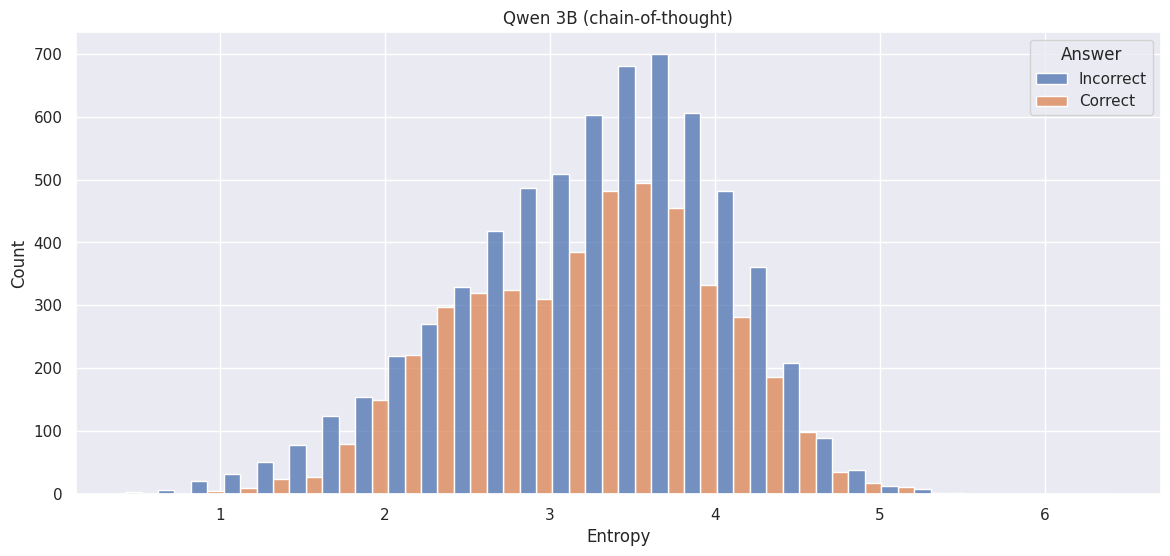

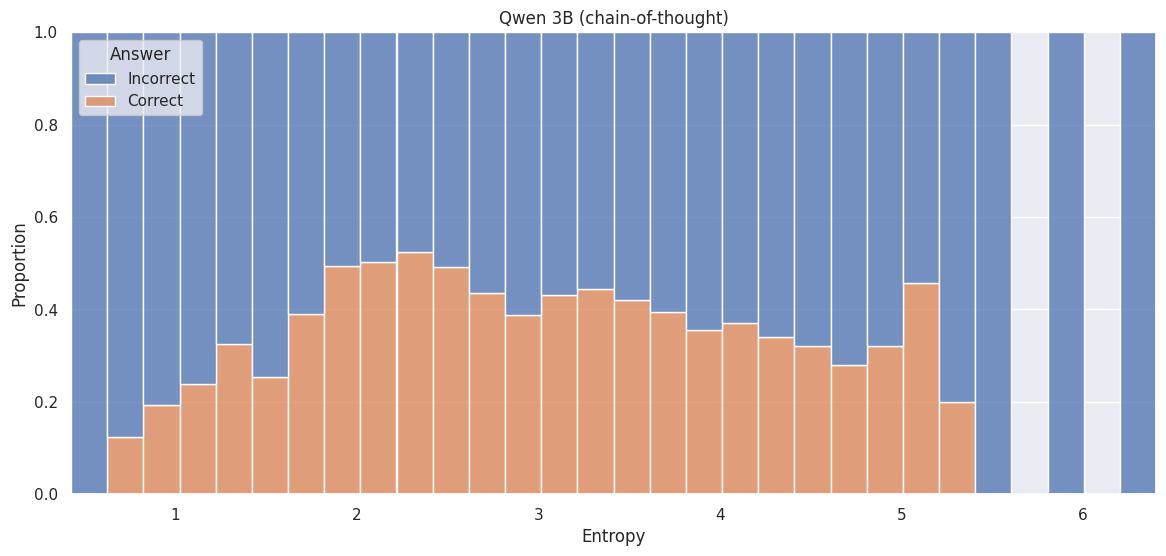

In [ ]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered, "qwen2_answer_entropy_marg", "qwen2_ans_correct", model_name="Qwen 3B (chain-of-thought)"
)


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col="qwen2_answer_entropy_marg",
    model_name=model_title,
)
roc_auc_res

<h2>Mean of Marginal difference of 2 highest probs for each token<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.584784,0.169569,11049,0.411802,Qwen-3b,qwen2_prob_diff_ent
1,law,0.474673,0.050653,1099,0.238399,Qwen-3b,qwen2_prob_diff_ent
2,business,0.641821,0.283642,734,0.452316,Qwen-3b,qwen2_prob_diff_ent
3,psychology,0.624391,0.248782,792,0.507576,Qwen-3b,qwen2_prob_diff_ent
4,chemistry,0.613628,0.227256,935,0.414973,Qwen-3b,qwen2_prob_diff_ent
5,biology,0.562696,0.125392,707,0.561528,Qwen-3b,qwen2_prob_diff_ent
6,history,0.530884,0.061769,380,0.355263,Qwen-3b,qwen2_prob_diff_ent
7,other,0.535516,0.071032,912,0.383772,Qwen-3b,qwen2_prob_diff_ent
8,physics,0.608105,0.216210,1126,0.417407,Qwen-3b,qwen2_prob_diff_ent
9,computer science,0.610760,0.221520,391,0.365729,Qwen-3b,qwen2_prob_diff_ent


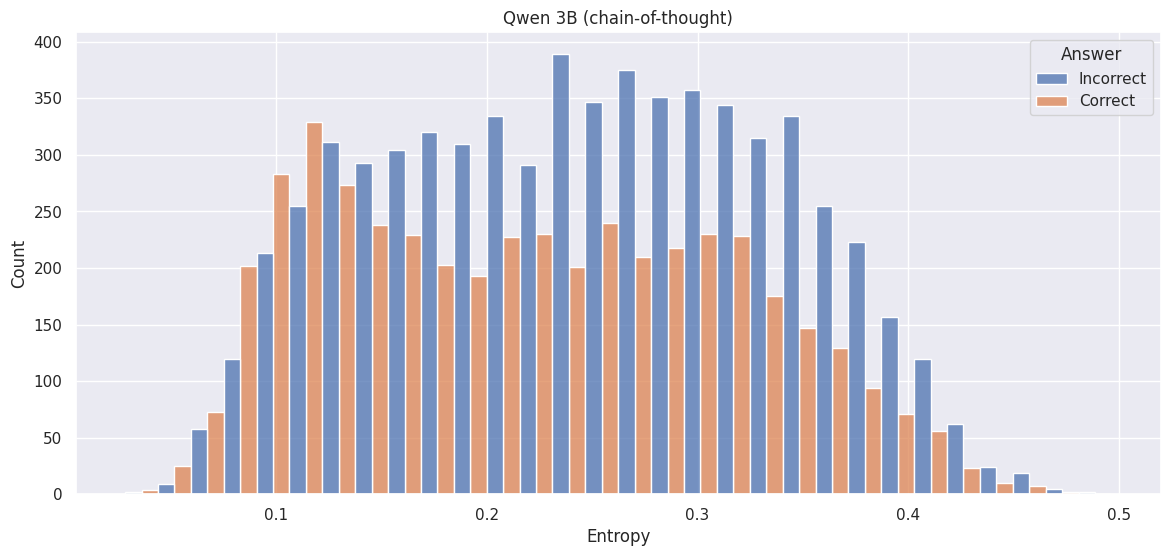

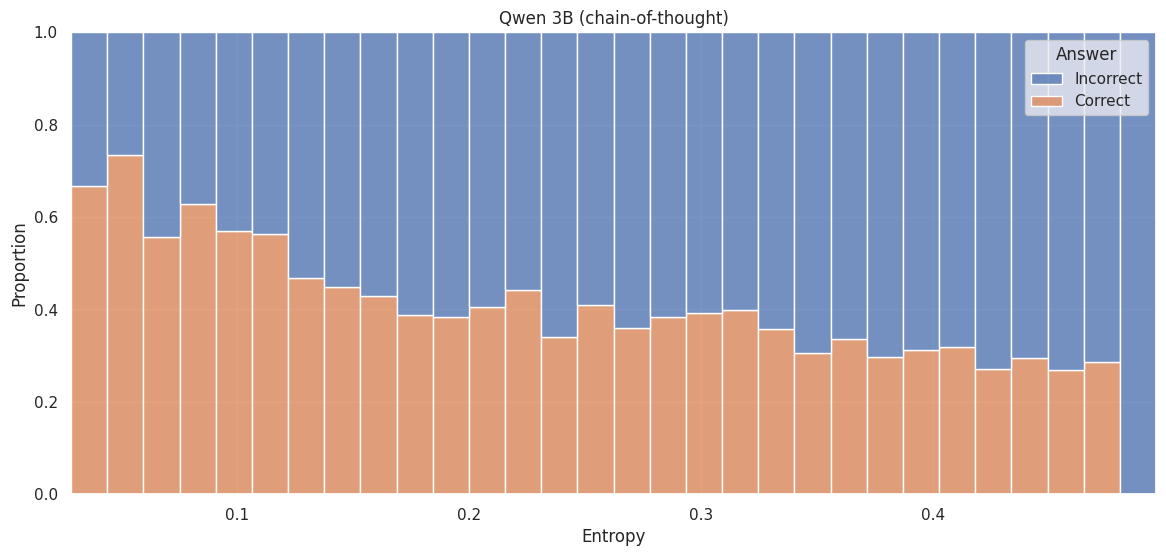

In [201]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered, "qwen2_prob_diff_ent", "qwen2_ans_correct", model_name="Qwen 3B (chain-of-thought)"
)


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col="qwen2_prob_diff_ent",
    model_name=model_title,
)
roc_auc_res


In [ ]:
import seaborn as sns


def visualize_entropy_by_category(df, category, x, hue, model_name=None):
    for cat in df[category].unique():
        plt.figure(figsize=(14, 6))
        ax = sns.histplot(
            df.loc[df[category].isin([cat]), :],
            x=x,
            hue=hue,
            hue_order=[False, True],
            multiple="dodge",
        )
        ax.set_xlabel("Entropy")
        ax.set_ylabel("Count")
        ax.set_title(cat if model_name is None else f"{cat} ({model_name})")
        plt.legend(handles=ax.get_legend().legend_handles, labels=["Incorrect", "Correct"], title="Answer")


In [54]:
from dataclasses import dataclass

import pandas as pd
from sklearn.metrics import roc_auc_score


def normalize_score(column):
    return 1 - column / column.max()


@dataclass
class ROC_AUC:
    roc_auc: float
    gini: float


def calculate_roc_auc(y_true, y_score):
    roc_auc = roc_auc_score(y_true, y_score)
    gini = abs(2 * roc_auc - 1)
    return ROC_AUC(roc_auc=roc_auc, gini=gini)


def calculate_accuracy(df, model_answer_correct_col):
    return df[model_answer_correct_col].sum() / len(df)


def calculate_roc_auc_by_category(df, model_name, category_col, model_answer_correct_col, score_col, threshold=10):
    results = []

    roc_auc = calculate_roc_auc(df[model_answer_correct_col], normalize_score(df[score_col]))

    results.append(
        {
            "category": "ALL",
            "roc_auc": roc_auc.roc_auc,
            "gini": roc_auc.gini,
            "num_samples": len(df),
            "accuracy": calculate_accuracy(df, model_answer_correct_col),
            "model": model_name,
            "metric": score_col,
        }
    )

    for category in df[category_col].unique():
        df_cat = df[df[category_col] == category]
        if len(df_cat) < threshold:
            continue

        roc_auc = calculate_roc_auc(df_cat[model_answer_correct_col], normalize_score(df_cat[score_col]))

        results.append(
            {
                "category": category,
                "roc_auc": roc_auc.roc_auc,
                "gini": roc_auc.gini,
                "num_samples": len(df_cat),
                "accuracy": calculate_accuracy(df_cat, model_answer_correct_col),
                "model": model_name,
                "metric": score_col,
            }
        )

    return pd.DataFrame(results)

In [ ]:
# from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category
model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col="qwen2_answer_entropy_top_diff",
    model_name=model_title,
)
roc_auc_res


,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.510655,0.021310,11063,0.411281,Qwen-3b,qwen2_answer_entropy_top_diff
1,law,0.517743,0.035487,1099,0.238399,Qwen-3b,qwen2_answer_entropy_top_diff
2,business,0.528300,0.056600,734,0.452316,Qwen-3b,qwen2_answer_entropy_top_diff
3,psychology,0.508694,0.017387,792,0.507576,Qwen-3b,qwen2_answer_entropy_top_diff
4,chemistry,0.491367,0.017265,936,0.414530,Qwen-3b,qwen2_answer_entropy_top_diff
5,biology,0.537393,0.074787,707,0.561528,Qwen-3b,qwen2_answer_entropy_top_diff
6,history,0.494664,0.010673,380,0.355263,Qwen-3b,qwen2_answer_entropy_top_diff
7,other,0.529038,0.058077,913,0.383352,Qwen-3b,qwen2_answer_entropy_top_diff
8,physics,0.521442,0.042884,1126,0.417407,Qwen-3b,qwen2_answer_entropy_top_diff
9,computer science,0.461148,0.077703,394,0.362944,Qwen-3b,qwen2_answer_entropy_top_diff


<h2>Answer Entropy and Max COT mixed<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.702624,0.405247,11049,0.411802,Qwen-3b,qwen2_answer_entropy_max_ans_entropy_mix
1,law,0.589241,0.178482,1099,0.238399,Qwen-3b,qwen2_answer_entropy_max_ans_entropy_mix
2,business,0.738132,0.476263,734,0.452316,Qwen-3b,qwen2_answer_entropy_max_ans_entropy_mix
3,psychology,0.709083,0.418166,792,0.507576,Qwen-3b,qwen2_answer_entropy_max_ans_entropy_mix
4,chemistry,0.692064,0.384129,935,0.414973,Qwen-3b,qwen2_answer_entropy_max_ans_entropy_mix
5,biology,0.762347,0.524693,707,0.561528,Qwen-3b,qwen2_answer_entropy_max_ans_entropy_mix
6,history,0.617203,0.234407,380,0.355263,Qwen-3b,qwen2_answer_entropy_max_ans_entropy_mix
7,other,0.648053,0.296106,912,0.383772,Qwen-3b,qwen2_answer_entropy_max_ans_entropy_mix
8,physics,0.726544,0.453088,1126,0.417407,Qwen-3b,qwen2_answer_entropy_max_ans_entropy_mix
9,computer science,0.675502,0.351004,391,0.365729,Qwen-3b,qwen2_answer_entropy_max_ans_entropy_mix


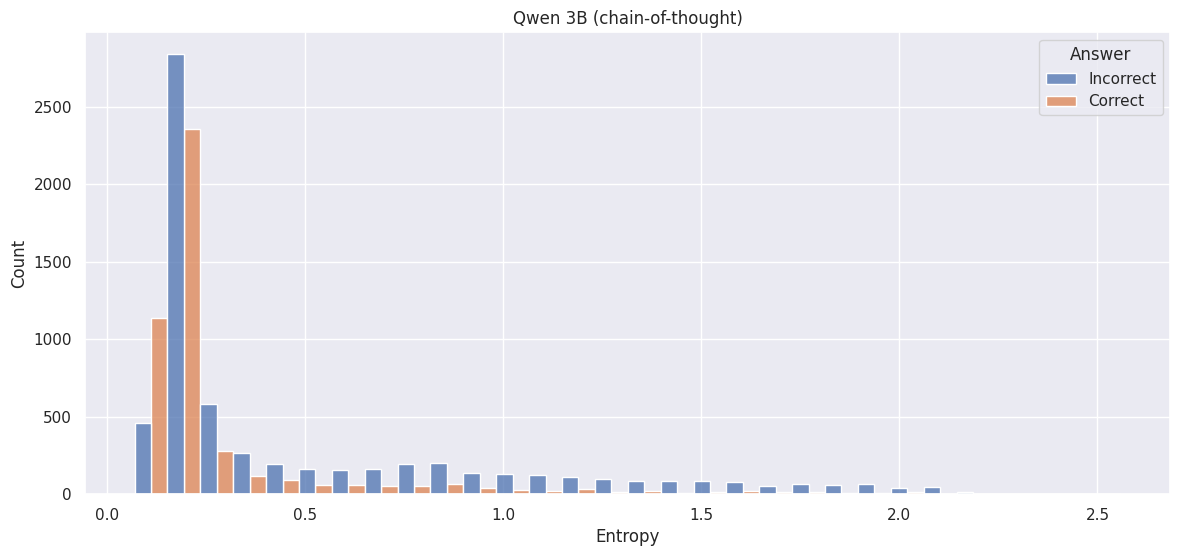

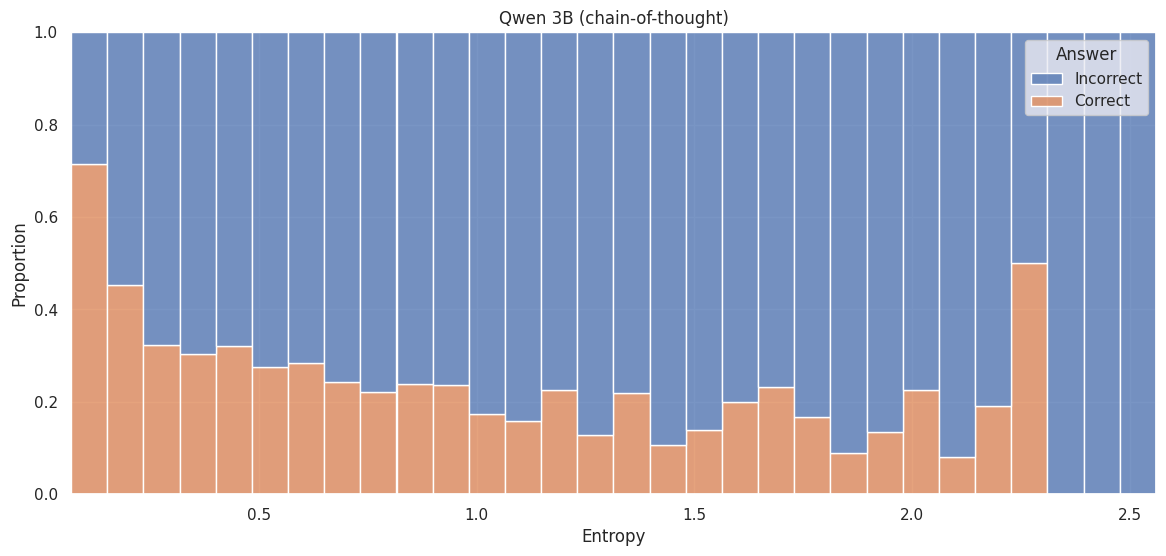

In [ ]:
name = "qwen2_answer_entropy_max_ans_entropy_mix"


def aver(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    answer_token_entropy = entropies[row[column_ans_token_index]]
    return 0.05 * np.max([ind for ind in entropies]) + 0.95 * answer_token_entropy


mmlu_entropy_df_filtered[name] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "qwen2_entropies", "qwen2_ans_token_index"), axis=1
)

from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(mmlu_entropy_df_filtered, name, "qwen2_ans_correct", model_name="Qwen 3B (chain-of-thought)")


# from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category
model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="qwen2_ans_correct",
    score_col=name,
    model_name=model_title,
)
roc_auc_res


In [ ]:
def calculate_entropies(data):
    entropies = []
    for sublist in data:
        # Extract all probabilities from the sublist
        probs = torch.softmax(torch.Tensor([item["token_prob"] for item in sublist]), -1)

        # Sort probabilities in descending order
        sorted_probs = sorted(probs, reverse=True)

        # Calculate entropy as difference between top two probabilities
        if len(sorted_probs) >= 2:
            entropy = sorted_probs[0] - sorted_probs[1]
        else:
            entropy = 0.0  # or handle as you see fit for lists with < 2 elements

        entropies.append(entropy)

    return entropies